In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, GRU

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id = '14CIFkC08NKcl5t82P2gITloOKKY8Lpio'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('data.csv')  

data_path = '/content/data.csv'
data = pd.read_csv(data_path).drop(['time_period_start', 'time_period_end'], axis=1)
data.head()

,price_open,price_high,price_low,price_close,volume_traded,reddit_sentiment,pos_keywords_occur,neg_keywords_occur
0,38320.00,38417.80,38319.99,38394.98,92.019354,0.0,0,0
1,38381.19,38381.19,38230.81,38257.69,3.200295,0.0,0,0
2,38251.68,38361.29,38247.05,38361.29,3.536984,0.0,0,0
3,38375.70,38485.00,38375.70,38455.46,9.787897,0.0,0,0
4,38446.95,38556.27,38446.95,38556.27,30.134611,0.0,0,0


In [3]:
data_features = data.drop(['price_close'], axis=1)
data_labels = data['price_close']

scaler_feature = MinMaxScaler(feature_range=(0, 1))
scaler_label = MinMaxScaler(feature_range=(0, 1))

feature = scaler_feature.fit_transform(data_features.to_numpy())
label = scaler_label.fit_transform(data_labels.to_numpy().reshape(-1, 1))


In [4]:
train_size1 = int(0.7 * len(label))
train_size2 = int(0.9 * len(label))
def split_data(f, l):
    delay = 1
    feature, label = [], []

    for i in range(len(f) - delay):
        feature.append(f[i: i + delay])
        label.append(l[i + delay-1])
        
    return np.array(feature), np.array(label).squeeze()

X_train, y_train = split_data(feature[:train_size1], label[:train_size1])
X_train2, y_train2 = split_data(feature[train_size1:train_size2], label[train_size1:train_size2])
X_test, y_test = split_data(feature[train_size2:], label[train_size2:])

In [5]:
LSTMUnits = 1024
DROPOUT = 0.1
EPOCHS = 70
BATCH_SIZE = 4096
LEARNING_RATE = 1e-3
DECAY_RATE = -0.6
checkpoint_filepath = 'bestmodel.hdf5'

def lr_scheduler(epoch, lr):
    if epoch % 10== 0 and epoch > 0:
        lr *= tf.math.exp(DECAY_RATE)
    
    return lr

models = [
    keras.Sequential([
        LSTM(units=LSTMUnits),
        Dropout(rate=DROPOUT),
        Dense(units=1)
    ]) for i in range(5)
]

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_root_mean_squared_error',
    mode='min',
    save_best_only=True, 
    verbose=1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)

for i, model in enumerate(models):
  model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=[tf.keras.metrics.RootMeanSquaredError()])
  history = model.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, y_test), 
                    shuffle=False,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath='LSTM'+str(i)+'.h5', monitor='val_root_mean_squared_error', mode='min', save_best_only=True,  verbose=1), lr_scheduler_callback]
                    )



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/70
93/94 [============================>.] - ETA: 0s - loss: 0.0230 - root_mean_squared_error: 0.1517
Epoch 1: val_root_mean_squared_error improved from inf to 0.16193, saving model to LSTM0.h5
94/94 [==============================] - 11s 37ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0262 - val_root_mean_squared_error: 0.1619 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/70
93/94 [============================>.] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0792
Epoch 2: val_root_mean_squared_error improved from 0.16193 to 0.10078, saving model to LSTM0.h5
94/94 [==============================] - 3s 31ms/step - loss: 0.0063 - root_mean_squared_error: 0.0792 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1008 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3

In [7]:
models = []
for i in range(5):
  models.append(tf.keras.models.load_model('LSTM'+str(i)+'.h5'))

In [8]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test))

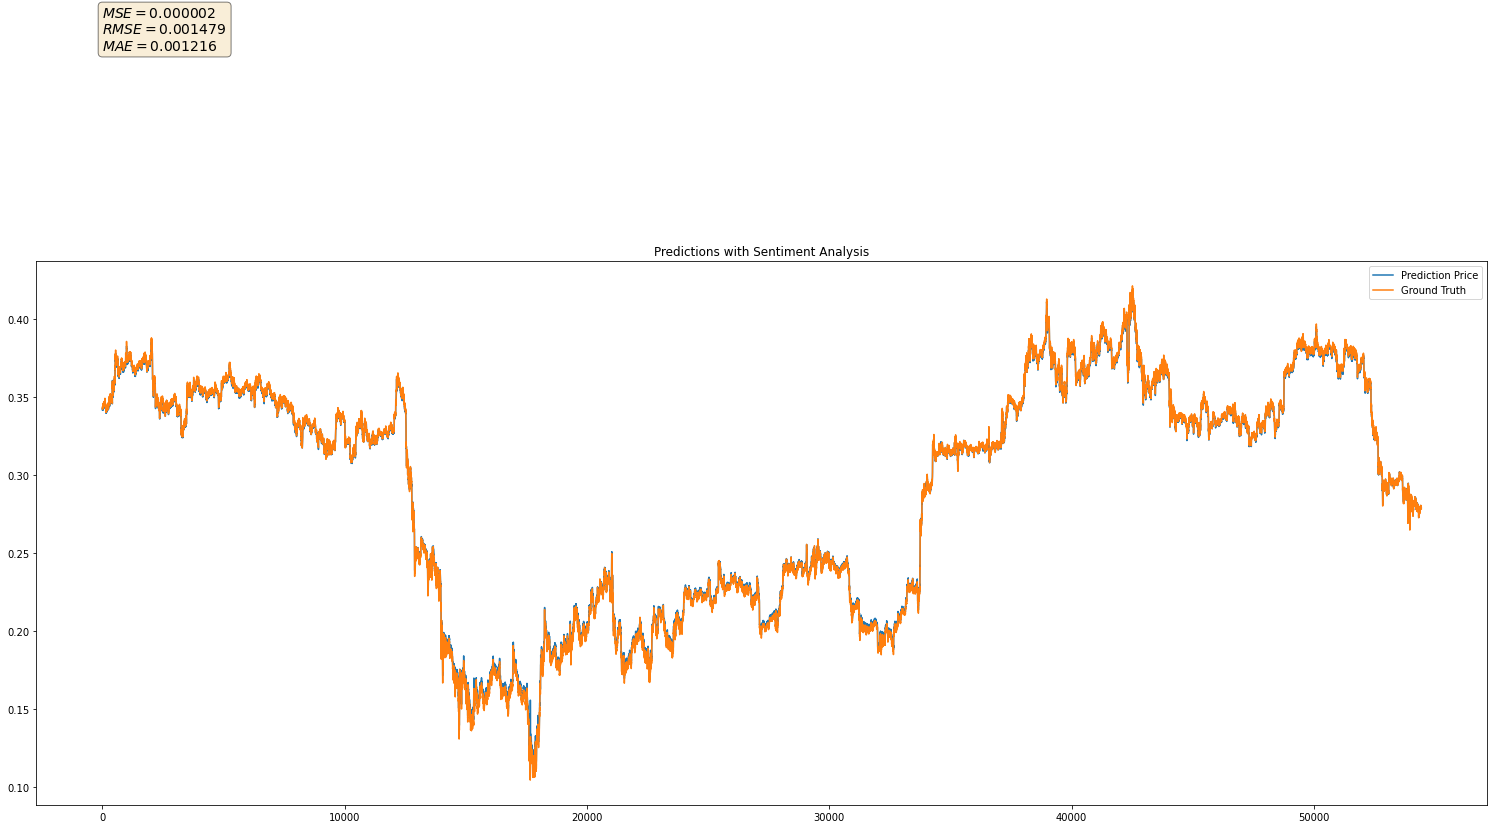

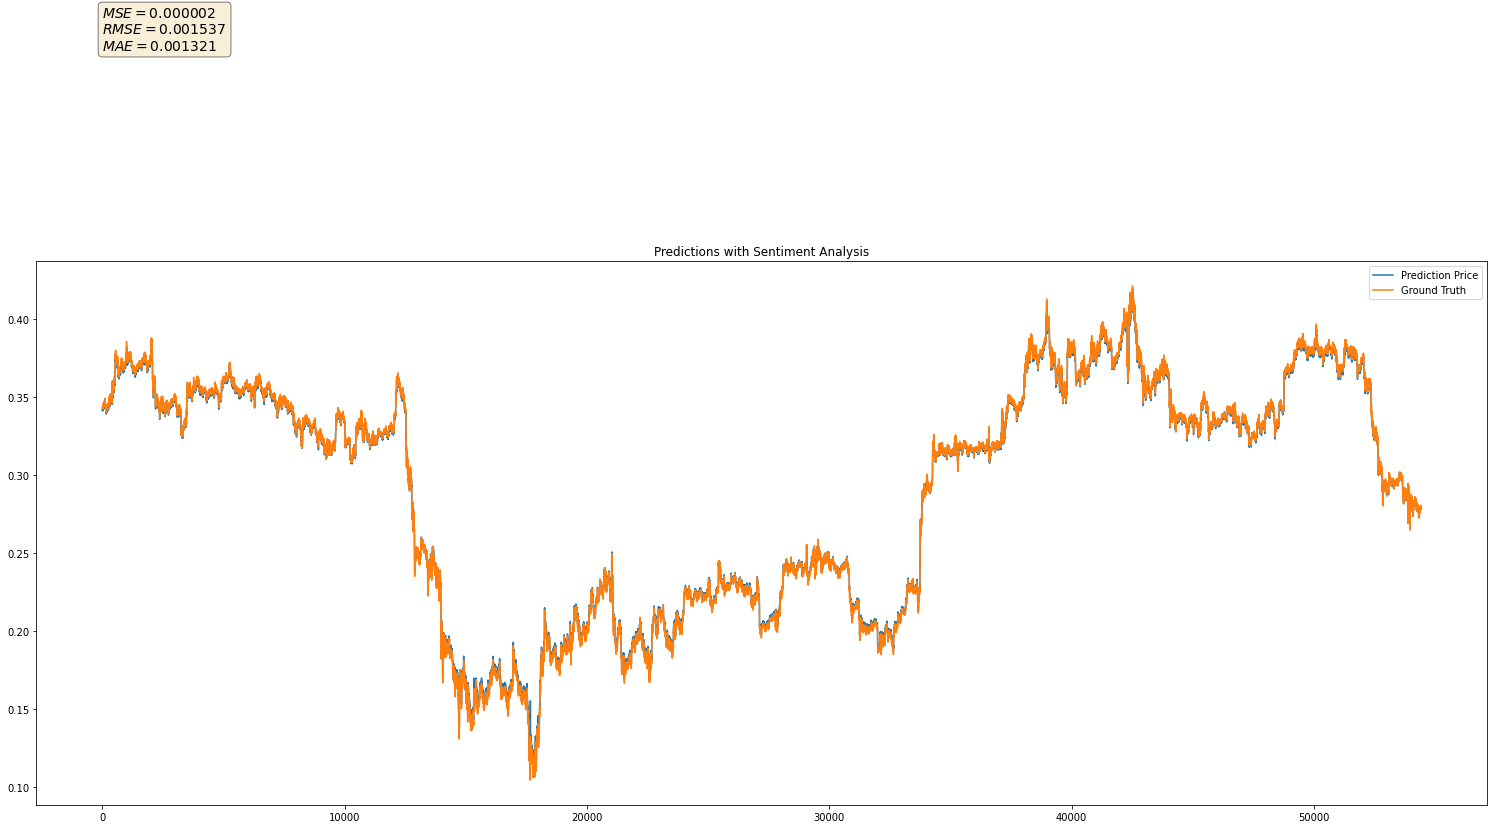

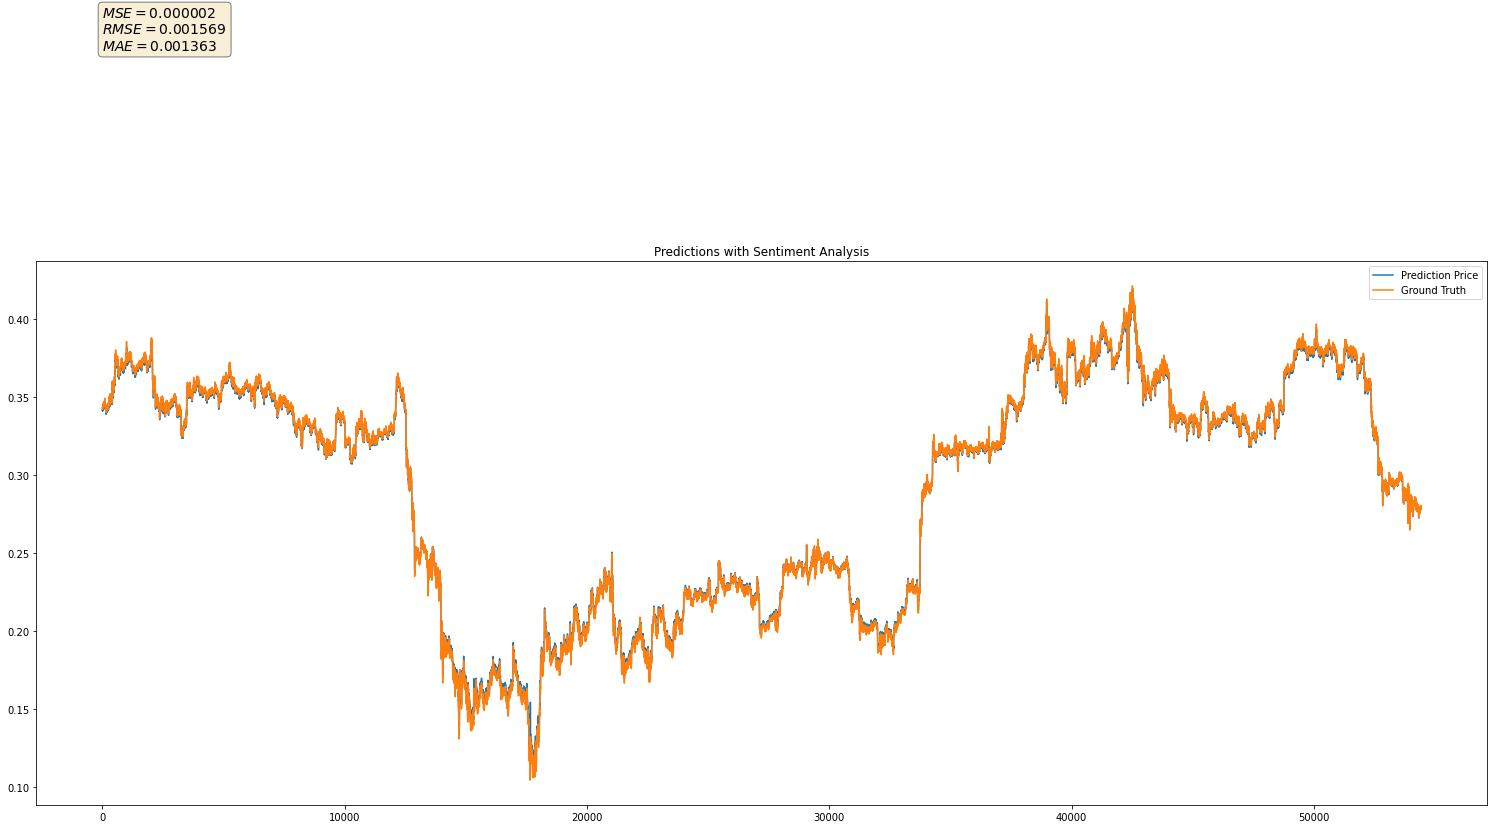

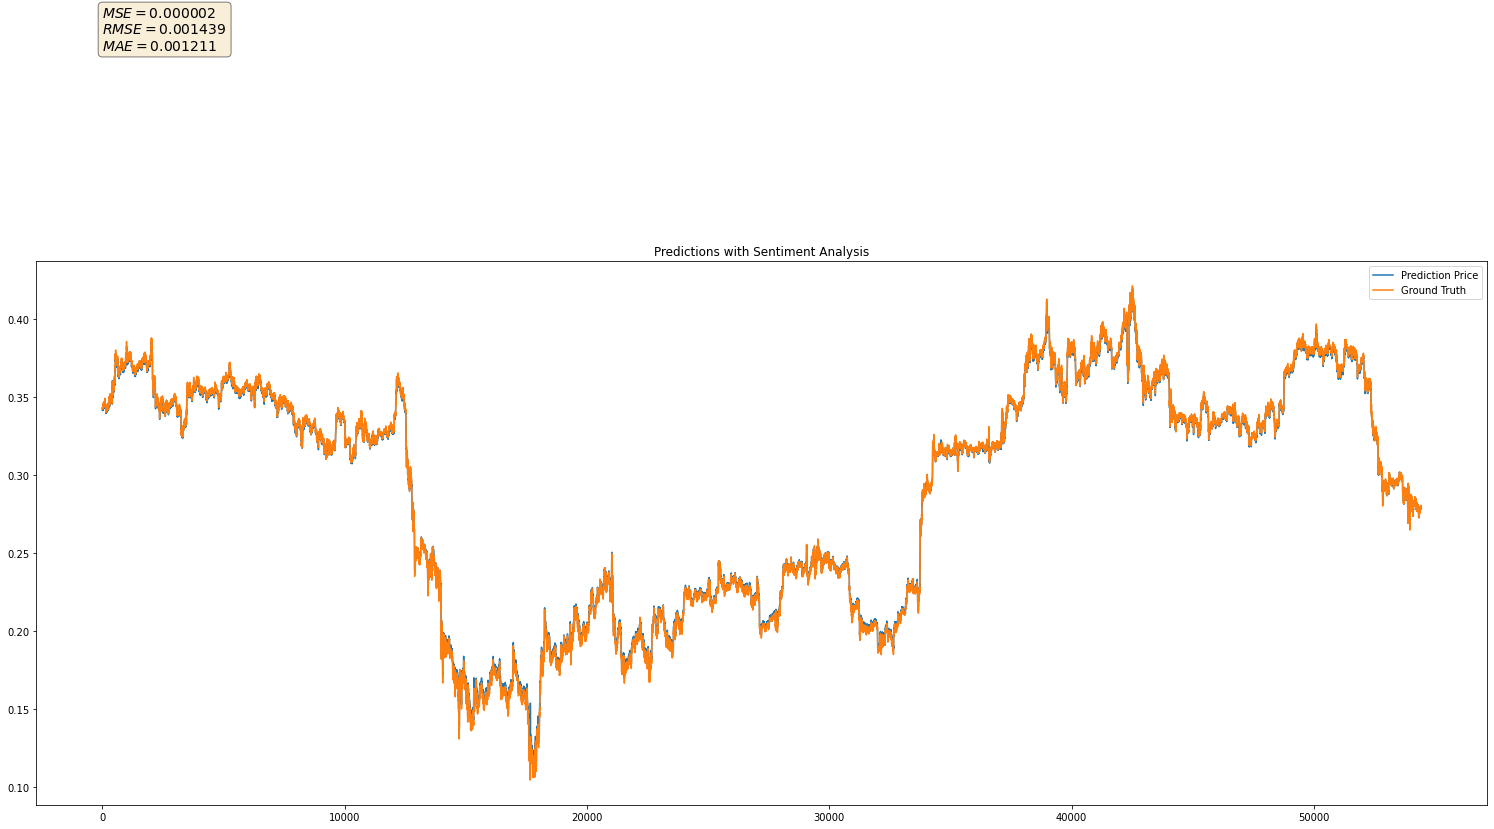

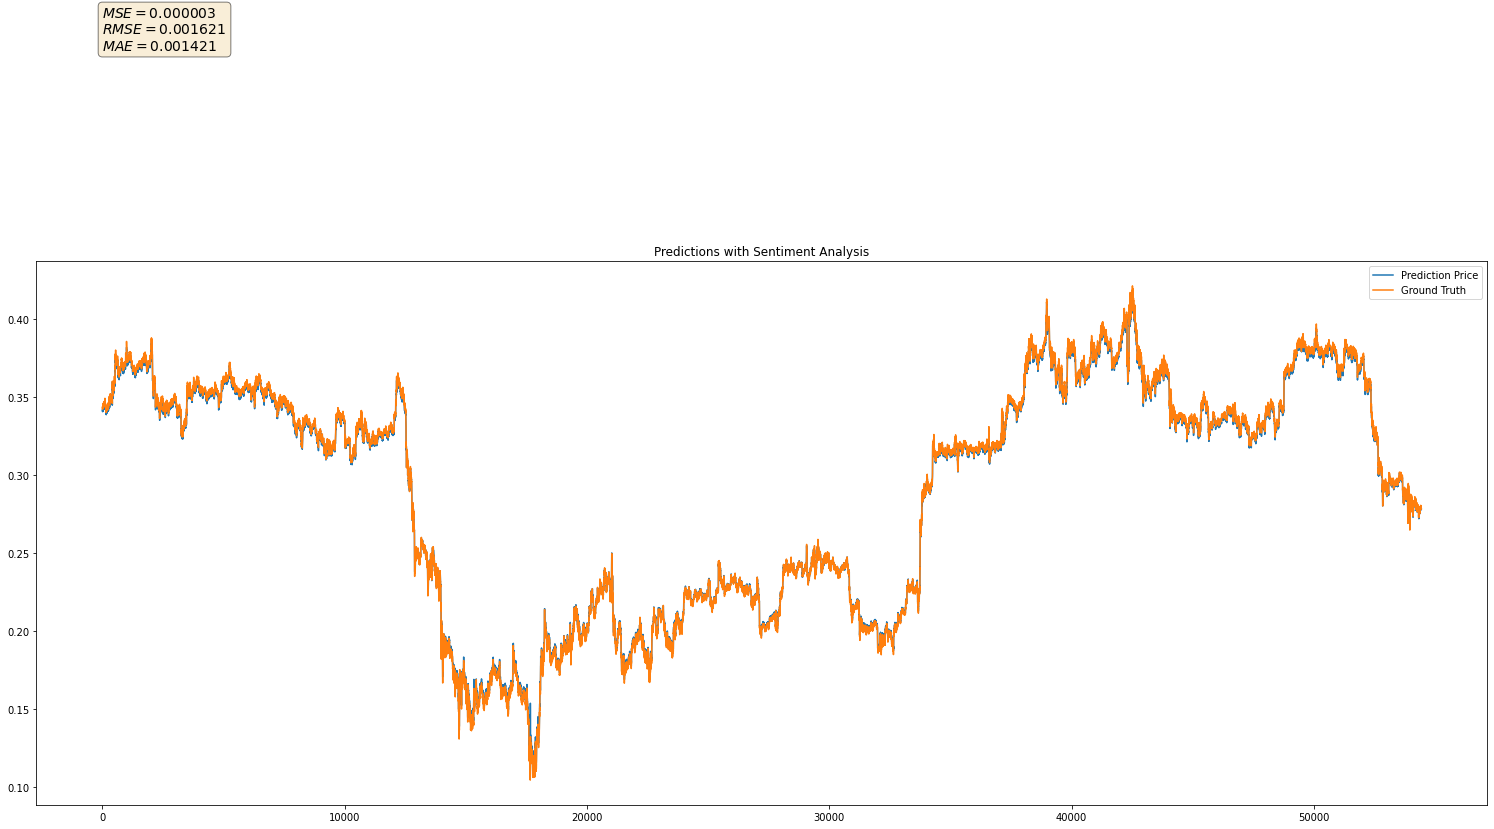

In [9]:
# prediction = model.predict(X_test)
for prediction in predictions:
    mse = mean_squared_error(y_test, prediction)
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mae = mean_absolute_error(y_test, prediction)

    metrics = '\n'.join((
        '$MSE=%f$' % (mse),
        '$RMSE=%f$' % (rmse),
        '$MAE=%f$' % (mae)
    ))

    plt.figure(figsize=(26, 10))
    plt.plot(prediction, label='Prediction Price')
    plt.plot(y_test, label='Ground Truth')
    plt.legend()
    plt.title('Predictions with Sentiment Analysis')

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.1, 0.6, metrics, fontsize=14,
            verticalalignment='top', bbox=props)

    # plt.savefig('no_senti.png', dpi=500)
    plt.show()

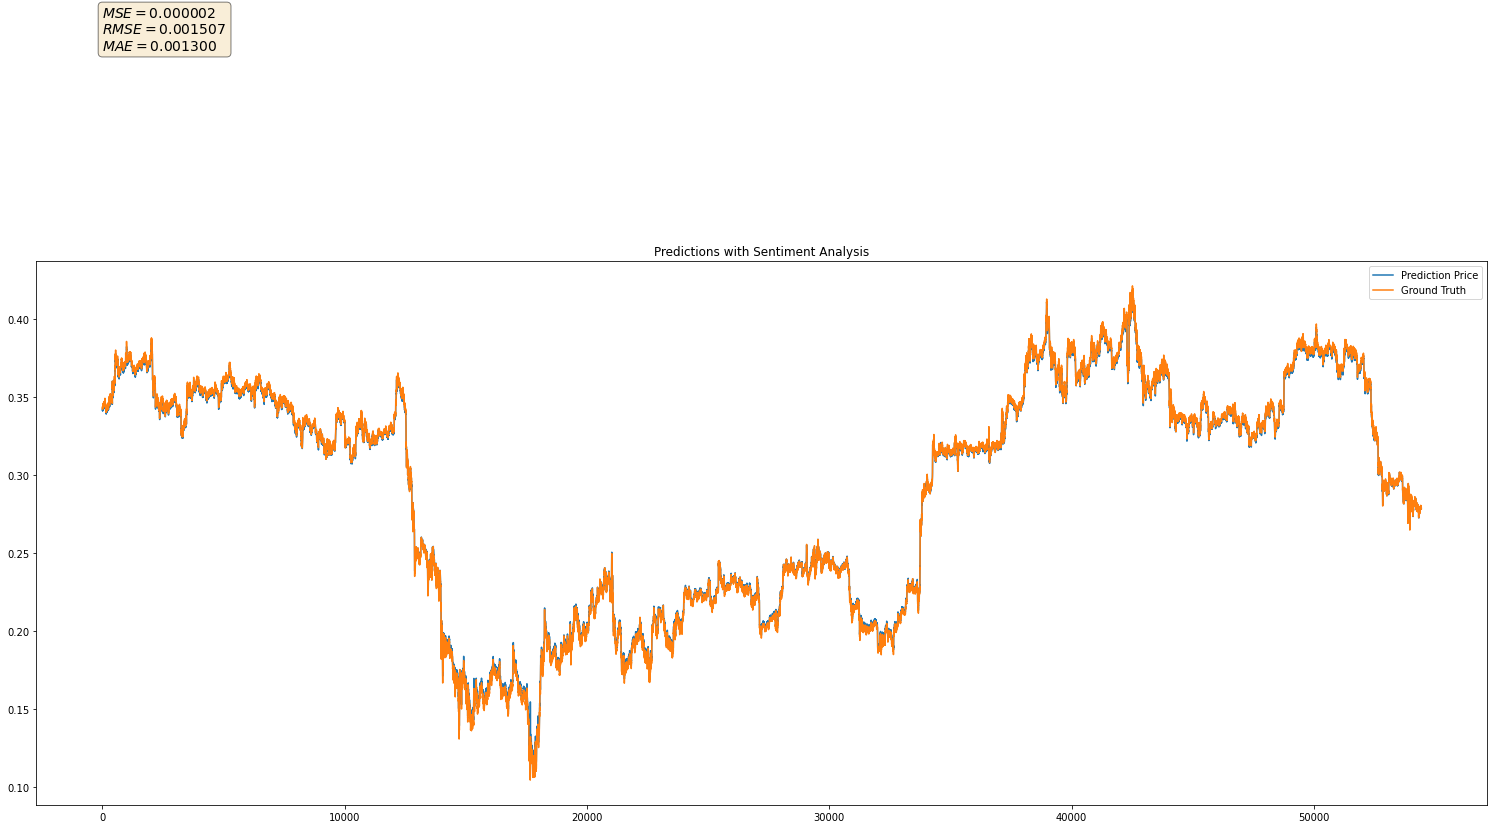

In [10]:
prediction = np.mean(np.array(predictions), axis=0)
mse = mean_squared_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)
mae = mean_absolute_error(y_test, prediction)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(prediction, label='Prediction Price')
plt.plot(y_test, label='Ground Truth')
plt.legend()
plt.title('Predictions with Sentiment Analysis')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.1, 0.6, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()

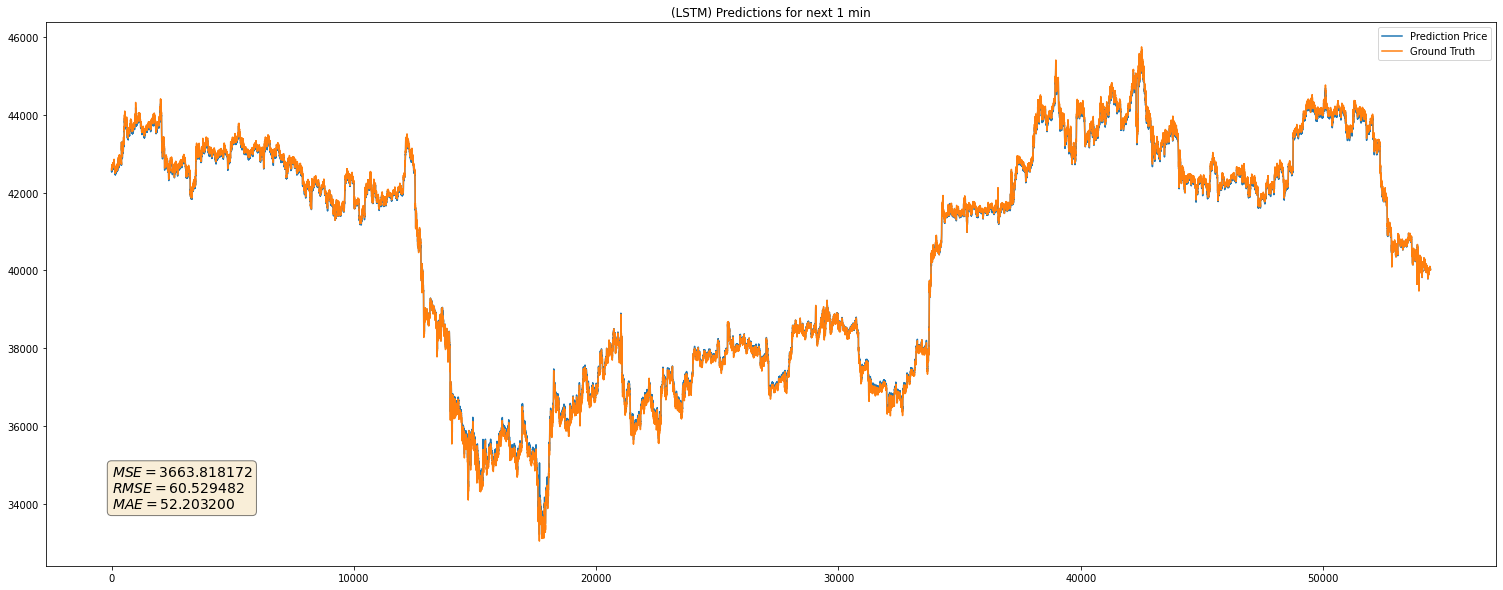

In [11]:
pred_prices = scaler_label.inverse_transform(prediction)
true_prices = scaler_label.inverse_transform(y_test.reshape(-1,1))

mse = mean_squared_error(true_prices, pred_prices)
rmse = mean_squared_error(true_prices, pred_prices, squared=False)
mae = mean_absolute_error(true_prices, pred_prices)

metrics = '\n'.join((
    '$MSE=%f$' % (mse),
    '$RMSE=%f$' % (rmse),
    '$MAE=%f$' % (mae)
))

plt.figure(figsize=(26, 10))
plt.plot(pred_prices, label='Prediction Price')
plt.plot(true_prices, label='Ground Truth')
plt.legend()
plt.title('(LSTM) Predictions for next 1 min')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0, 35000, metrics, fontsize=14,
        verticalalignment='top', bbox=props)

# plt.savefig('no_senti.png', dpi=500)
plt.show()